In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import seaborn as sns
import random
import timm
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

!pip install torch efficientnet_pytorch
from efficientnet_pytorch import EfficientNet

from transformers import BertModel, BertTokenizer
from transformers import XLNetModel, XLNetTokenizer
from transformers import BertForSequenceClassification, XLNetForSequenceClassification

import warnings
warnings.filterwarnings('ignore')

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=223b0b9843edc521c2a240f33176241f881ff2496a8ceb58be009f756bdf7359
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [2]:
def seed_everything(seed):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(50)

In [3]:
# import re
# import nltk
# from nltk.corpus import stopwords

# nltk.download('stopwords')
# stop_words = set(stopwords.words('english'))

# def preprocess_text(text):
#     text = re.sub(r'[^a-zA-Z\s]', '', text)
#     text = ' '.join([word for word in text.split() if word not in stop_words])
#     return text

# def merge_tags(tags):
#     if tags is None:
#         return ''
#     return ' '.join(tags)

def preprocess_data(data):
    data = data.fillna('.')
#     data['title'] = data['title'].apply(preprocess_text)
#     data['description'] = data['description'].apply(preprocess_text)
#     data['user_tags'] = data['user_tags'].apply(merge_tags).apply(preprocess_text)
    return data




In [4]:
# def remove_brackets(text):
#     if isinstance(text, list):
#         text = ', '.join(text)
#     return text

In [5]:
import json

def read_json(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return pd.DataFrame(data['images'])

train_df = read_json('/kaggle/input/dataset/devset_images_metadata.json')
TRAIN_LABEL_PATH = '/kaggle/input/dataset/devset_images_gt.csv'
label_csv = pd.read_csv(TRAIN_LABEL_PATH)
label_csv = label_csv.rename(columns={'id': 'image_id'})
train_df['image_id'] = train_df['image_id'].astype(int)
train_df = train_df.merge(label_csv, on='image_id', how='inner')
train_df = train_df.drop(['license_name', 'user_nsid', 'image_extension_original', 'longitude','license_url','date_uploaded','date_taken','latitude','image_url','capture_device','user_nickname'], axis=1)


In [6]:
train_df

,description,user_tags,title,image_id,label
0,None,"[2009 road trip, obrero road trip]",Biltmore Estate,3519864665,0
1,None,"[daulatabad, daulatabad fort, ellora, road trip]",Chand Minar,4896119055,0
2,"After the flood, the boarded up stores bear up...","[cedarrapids, createsouthroadtrip2009, disaste...",Uplifting Graffiti,3468473862,0
3,None,"[cork, enchente, flood, ireland, irlanda]",DSCF6487,4120853942,0
4,None,"[athens georgia, brown, current, flood, mud, r...",Oconoe river - flooded,4436083254,0
...,...,...,...,...,...
5275,None,"[550d, camino, canon, canoneos550d, canoneoski...",90,8119782888,0
5276,None,"[albany, ny, flood, walk, water]","Albany's Corning Preserve, day after Irene",6093294301,1
5277,None,"[al, the waters in pike road]",IMG_4989,6791185487,0
5278,2013 Fair Flood,"[2013, county, fair, flood, linn]",IMG_3011,9144682941,0


In [7]:

# train_df['user_tags'] = train_df['user_tags'].apply(remove_brackets)


In [8]:
train_df 

,description,user_tags,title,image_id,label
0,None,"[2009 road trip, obrero road trip]",Biltmore Estate,3519864665,0
1,None,"[daulatabad, daulatabad fort, ellora, road trip]",Chand Minar,4896119055,0
2,"After the flood, the boarded up stores bear up...","[cedarrapids, createsouthroadtrip2009, disaste...",Uplifting Graffiti,3468473862,0
3,None,"[cork, enchente, flood, ireland, irlanda]",DSCF6487,4120853942,0
4,None,"[athens georgia, brown, current, flood, mud, r...",Oconoe river - flooded,4436083254,0
...,...,...,...,...,...
5275,None,"[550d, camino, canon, canoneos550d, canoneoski...",90,8119782888,0
5276,None,"[albany, ny, flood, walk, water]","Albany's Corning Preserve, day after Irene",6093294301,1
5277,None,"[al, the waters in pike road]",IMG_4989,6791185487,0
5278,2013 Fair Flood,"[2013, county, fair, flood, linn]",IMG_3011,9144682941,0


In [9]:
train_df = preprocess_data(train_df)


In [10]:
train_df

,description,user_tags,title,image_id,label
0,.,"[2009 road trip, obrero road trip]",Biltmore Estate,3519864665,0
1,.,"[daulatabad, daulatabad fort, ellora, road trip]",Chand Minar,4896119055,0
2,"After the flood, the boarded up stores bear up...","[cedarrapids, createsouthroadtrip2009, disaste...",Uplifting Graffiti,3468473862,0
3,.,"[cork, enchente, flood, ireland, irlanda]",DSCF6487,4120853942,0
4,.,"[athens georgia, brown, current, flood, mud, r...",Oconoe river - flooded,4436083254,0
...,...,...,...,...,...
5275,.,"[550d, camino, canon, canoneos550d, canoneoski...",90,8119782888,0
5276,.,"[albany, ny, flood, walk, water]","Albany's Corning Preserve, day after Irene",6093294301,1
5277,.,"[al, the waters in pike road]",IMG_4989,6791185487,0
5278,2013 Fair Flood,"[2013, county, fair, flood, linn]",IMG_3011,9144682941,0


In [11]:
import glob
train_images = glob.glob('/kaggle/input/dataset/devset_images/devset_images/*')
train_images[:5]

['/kaggle/input/dataset/devset_images/devset_images/6099582129.jpg',
 '/kaggle/input/dataset/devset_images/devset_images/2481944299.jpg',
 '/kaggle/input/dataset/devset_images/devset_images/6820987318.jpg',
 '/kaggle/input/dataset/devset_images/devset_images/864584409.jpg',
 '/kaggle/input/dataset/devset_images/devset_images/9349393459.jpg']

In [12]:
images_path = "/kaggle/input/dataset/devset_images/devset_images"


In [13]:
# train_df.to_csv('train_df.csv', index=False)

In [14]:
image_ids = [int(fp.split('/')[-1].split('.')[0]) for fp in train_images]

mapping = dict(zip(image_ids, train_images))

train_df['image_id'] = train_df['image_id'].map(mapping)

train_df

,description,user_tags,title,image_id,label
0,.,"[2009 road trip, obrero road trip]",Biltmore Estate,/kaggle/input/dataset/devset_images/devset_ima...,0
1,.,"[daulatabad, daulatabad fort, ellora, road trip]",Chand Minar,/kaggle/input/dataset/devset_images/devset_ima...,0
2,"After the flood, the boarded up stores bear up...","[cedarrapids, createsouthroadtrip2009, disaste...",Uplifting Graffiti,/kaggle/input/dataset/devset_images/devset_ima...,0
3,.,"[cork, enchente, flood, ireland, irlanda]",DSCF6487,/kaggle/input/dataset/devset_images/devset_ima...,0
4,.,"[athens georgia, brown, current, flood, mud, r...",Oconoe river - flooded,/kaggle/input/dataset/devset_images/devset_ima...,0
...,...,...,...,...,...
5275,.,"[550d, camino, canon, canoneos550d, canoneoski...",90,/kaggle/input/dataset/devset_images/devset_ima...,0
5276,.,"[albany, ny, flood, walk, water]","Albany's Corning Preserve, day after Irene",/kaggle/input/dataset/devset_images/devset_ima...,1
5277,.,"[al, the waters in pike road]",IMG_4989,/kaggle/input/dataset/devset_images/devset_ima...,0
5278,2013 Fair Flood,"[2013, county, fair, flood, linn]",IMG_3011,/kaggle/input/dataset/devset_images/devset_ima...,0


In [15]:
print(len(train_df))


5280


In [16]:
validdf= train_df[:528]

traindf= train_df[528:]

In [17]:
print(len(traindf))
print(len(validdf))

4752
528


In [18]:
transform_train = transforms.Compose([
    transforms.Resize((228, 228)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


transform_test = transforms.Compose([
    transforms.Resize((228, 228)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [19]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, images_path, transform=None):
        self.dataframe = dataframe
        self.images_path = images_path
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_name = os.path.join(self.images_path, self.dataframe.iloc[index]['image_id'])
        image = Image.open(img_name)
        label = self.dataframe.iloc[index]['label']

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [20]:
train_dataset = CustomDataset(traindf, images_path, transform=transform_train)
validation_dataset = CustomDataset(validdf, images_path, transform=transform_test)

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [22]:
class_counts = traindf['label'].value_counts()
class_weights = torch.tensor([1.0 / class_counts[i] for i in range(len(class_counts))])
class_weights = class_weights / class_weights.sum()

In [23]:
class_weights = class_weights.to(device,dtype=torch.float32)


In [24]:
class CustomDenseNet(nn.Module):
    def __init__(self, num_classes):
        super(CustomDenseNet, self).__init__()
        densenet = models.densenet201(pretrained=True)
        for param in densenet.parameters():
            param.requires_grad = False
        self.densenet = nn.Sequential(*list(densenet.children())[:-1])
        self.fc = nn.Linear(densenet.classifier.in_features, num_classes)
        
    def forward(self, x):
        x = self.densenet(x)
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [25]:
model = CustomDenseNet(num_classes=2)


Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:00<00:00, 149MB/s] 


In [26]:
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader= DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

In [27]:
model.to(device)


CustomDenseNet(
  (densenet): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=

In [28]:
learning_rate = 0.0001
momentum = 0.9
beta_2 = 0.999
epsilon = 1e-8
weight_decay = 0.0
amsgrad = False

In [29]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(),
                       lr=learning_rate)

num_iters=10000
num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

patience = 8
best_val_loss = float('inf')
counter = 0

In [31]:
iter= 0
train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        iter+=1

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()


    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct_predictions / total_samples
    train_loss_history.append(epoch_loss)
    train_acc_history.append(epoch_acc)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(valid_loader)
    epoch_acc = correct_predictions / total_samples
    test_loss_history.append(epoch_loss)
    test_acc_history.append(epoch_acc)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), 'best_model.pt')
        print("Best Model Save")
        model.train()
        
    else:
        counter += 1
        if counter >= patience:
            print(f'Early stopping at epoch {epoch + 1}.')
            break

Epoch [1/269], Train Loss: 0.5124, Accuracy: 0.7630
Epoch [1/269], Validation Loss: 0.4719, Accuracy: 0.8049
Best Model Save
Epoch [2/269], Train Loss: 0.4563, Accuracy: 0.8169
Epoch [2/269], Validation Loss: 0.4294, Accuracy: 0.8182
Best Model Save
Epoch [3/269], Train Loss: 0.4243, Accuracy: 0.8316
Epoch [3/269], Validation Loss: 0.3984, Accuracy: 0.8239
Best Model Save
Epoch [4/269], Train Loss: 0.3969, Accuracy: 0.8474
Epoch [4/269], Validation Loss: 0.3781, Accuracy: 0.8371
Best Model Save
Epoch [5/269], Train Loss: 0.3810, Accuracy: 0.8506
Epoch [5/269], Validation Loss: 0.3621, Accuracy: 0.8409
Best Model Save
Epoch [6/269], Train Loss: 0.3599, Accuracy: 0.8596
Epoch [6/269], Validation Loss: 0.3494, Accuracy: 0.8409
Best Model Save
Epoch [7/269], Train Loss: 0.3479, Accuracy: 0.8628
Epoch [7/269], Validation Loss: 0.3410, Accuracy: 0.8447
Best Model Save
Epoch [8/269], Train Loss: 0.3371, Accuracy: 0.8638
Epoch [8/269], Validation Loss: 0.3334, Accuracy: 0.8466
Best Model Save


In [33]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

model.load_state_dict(torch.load('best_model.pt'))
model.eval() 

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in valid_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

class_report = classification_report(all_labels, all_preds, target_names=['non_flood',  'flood'])

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Classification Report:\n", class_report)


Accuracy: 0.8561
Precision: 0.8554
Recall: 0.8561
F1 Score: 0.8557
Classification Report:
               precision    recall  f1-score   support

   non_flood       0.89      0.90      0.89       347
       flood       0.80      0.78      0.79       181

    accuracy                           0.86       528
   macro avg       0.84      0.84      0.84       528
weighted avg       0.86      0.86      0.86       528



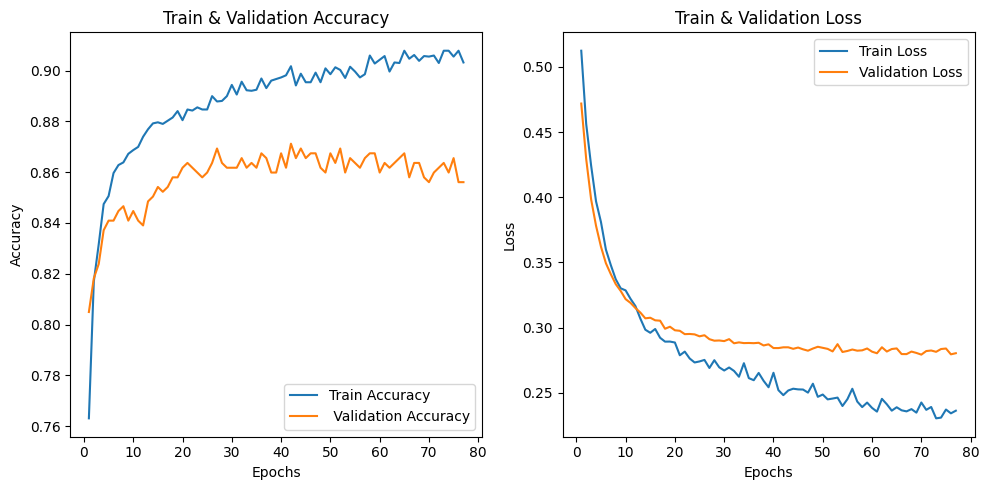

In [34]:
max_epochs = len(train_acc_history)-1
train_acc_history = train_acc_history[:max_epochs]
test_acc_history = test_acc_history[:max_epochs]

train_loss_history = train_loss_history[:max_epochs]
test_loss_history = test_loss_history[:max_epochs]

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, max_epochs+ 1), train_acc_history, label='Train Accuracy')
plt.plot(range(1, max_epochs + 1), test_acc_history, label=' Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train & Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(1, max_epochs + 1), train_loss_history, label='Train Loss')
plt.plot(range(1, max_epochs + 1), test_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train & Validation Loss')

plt.tight_layout()
plt.show()

In [ ]:
a